# Обучение сверточной нейросети на датасете HAM10000

## Импорт необходимых библиотек 

In [114]:
# General
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
import torch.optim as optim
# classic ML
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

In [33]:
num_epochs = 5
# num_classes = 8
batch_size = 4
learning_rate = 0.001

## Перевод изображений в тензоры

Все изображения изначально поделены на папки **train** и **test**. 
В каждой папке изображения лежат по папкам классов. 
На 1 класс одна папка. 
Количество представителей каждого из классов распределены в одинаковых пропорциях в train и test выборке. 
Про то как производилось распределение подробно в [блокноте](https://github.com/gurmaaan/MedNN/blob/master/Sort_img_into_folders.ipynb)

Определяем каскад трансформаций, который будут осуществляться над каждым изображением выборки перед попаданием на обучение / тестирование нейронной сети.

Каскад - массив трансформаций, каждая из которых будет применена к изображению последовательно одна за одной.
Каскад реализуется с помощью _Compose_.
* ToTensor - конвертирует изображение в Тензор 
* Normalize - приводит тензор к нормальному распределению со матожиданием ... и СКО ... МО и СКО указываются для каждой компоненты пикселя 

In [3]:
transform = transforms.Compose
(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    ]
)

[ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

Ниже игрушечный пример как работает трансформация изображений

In [4]:
from PIL import Image
img = Image.open('image.jpg')
d_t = transforms.ToTensor()(img)
# d_t[0][0]

Теперь дадим понять torch'у к каким изображениям применять описанную выше трансформацию и к каким классам относятся изображения.
Для этого используется класс ImageFolder.
Он загружает папку в которой изображения распиханы по классам-папкам как описано выше. 
```
/root/class1/11.jpg
/root/class1/12.jpg
/root/class2/21.jpg
/root/class2/22.jpg
```

In [6]:
train_folder = ImageFolder(root='train32', transform=transforms.ToTensor())
valid_folder = ImageFolder(root='valid32', transform=transforms.ToTensor())
# train_folder = ImageFolder(root='train', transform=transform)
# valid_folder = ImageFolder(root='valid', transform=transform)

Теперь я могу узнать размер выборки, распределение по классам, сами классы и т.д.

In [16]:
class_labels = list(train_folder.classes)
num_classes = len(class_labels)
class_labels

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [8]:
len(train_folder)

6710

После этого превратим наши изображения в тренировочную и тестовую выборки для будущей нейросети. 
Для этого используется класс DataLoader.
Он позволяет выдавать случайные выборки и многое другое. 
Выжный параметр деления всей тренировочной выборки на группы:
* batch_size - сколько изображений содержится в 1 группе

In [24]:
train_loader = DataLoader(train_folder, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_folder, batch_size=batch_size, shuffle=True)

Посмотрим что содержится в одном батче

In [58]:
train_iter = iter(train_loader)

In [65]:
train_images, train_labels = train_iter.next()

In [108]:
classes = train_folder.class_to_idx
classes_map = dict((v,k) for k,v in classes.items())

In [53]:
def label_encoder(class_dict, labels):
    print('Labels:', ' | '.join('%5s' % class_dict[l.item()] for l in labels))

In [62]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

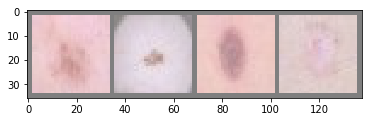

Labels: pigmented benign keratosis | nevus | nevus | nevus


In [66]:
imshow(torchvision.utils.make_grid(images))
label_encoder(classes_map, train_labels)

## Определение архитектуры нейросети

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
net = Net()
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)
10
torch.Size([6, 3, 5, 5])


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

## Обучаем нейросеть 

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Epoch {} ------------'.format(epoch))

print('Finished Training')

## Сохранение выученных коэффициентов

In [36]:
coeff_path = './pytorch_cnn_coeff.pth'
torch.save(net.state_dict(), coeff_path)

## Проверка нейросети на способность предсказания

Сначала грузим реальные картинки и метки классов

In [75]:
valid_iter = iter(valid_loader)

In [82]:
valid_images, valid_labels = valid_iter.next()

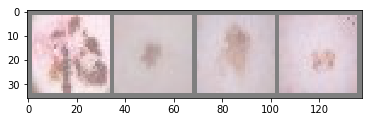

Labels: melanoma | nevus | nevus | nevus


In [83]:
imshow(torchvision.utils.make_grid(valid_images))
label_encoder(classes_map, valid_labels)

Теперь смотрим что угадает сеть

In [84]:
net = Net()
net.load_state_dict(torch.load(coeff_path))

<All keys matched successfully>

In [85]:
outputs = net(valid_images)

In [87]:
_, prediction = torch.max(outputs, 1)
label_encoder(classes_map, prediction)

Labels: melanoma | nevus | nevus | nevus


## Оценка accuracy всей валидационной выборки 

In [107]:
correct = 0
total = 0
real_labels = []
pred_labels = []

In [111]:
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for l in labels:
            real_labels.append(classes_map[l.item()])
        for p in predicted:
            pred_labels.append(classes_map[p.item()])

In [116]:
result_df = pd.DataFrame(list(zip(real_labels, pred_labels)), columns =['real', 'pred']) 
result_df.head()

,real,pred
0,actinic keratosis,pigmented benign keratosis
1,nevus,nevus
2,basal cell carcinoma,nevus
3,melanoma,nevus
4,nevus,nevus


In [119]:
result_df['answer'] = result_df.apply(lambda x: int(x['real'] == x['pred']), axis=1)
result_df.head()

,real,pred,answer
0,actinic keratosis,pigmented benign keratosis,0
1,nevus,nevus,1
2,basal cell carcinoma,nevus,0
3,melanoma,nevus,0
4,nevus,nevus,1


In [121]:
result_df.to_csv('result.csv')

In [145]:
print('Accuracy all classes: ', round(accuracy_score(result_df['real'], result_df['pred']) * 100, 2), '%')

Accuracy all classes:  70.83 %


## Оценка accuracy по классам 

In [137]:
classes = result_df['real'].unique()

In [146]:
for cl in classes:
    answ = result_df[result_df['real'] == cl]['answer']
    acc = round(100 * (sum(answ) / len(answ)), 2)
    print('Class {}. Accuracy: {}%'.format(cl, acc))

Class actinic keratosis. Accuracy: 0.0%
Class nevus. Accuracy: 95.19%
Class basal cell carcinoma. Accuracy: 9.09%
Class melanoma. Accuracy: 13.13%
Class pigmented benign keratosis. Accuracy: 45.19%
Class squamous cell carcinoma. Accuracy: 0.0%
Class dermatofibroma. Accuracy: 0.0%
Class vascular lesion. Accuracy: 0.0%
